# Topic Modeling Yelp Reviews By Sentiment
Capstone Project 2 - Miguel Montano

### Problem Statement:
I propose an approach that utilizes the existing rating system in Yelp reviews to infer sentiment, attributing low and high ratings to negative and positive sentiment respectively, and creating a Latent Dirichlet Allocation (LDA) topic model for each set, extracting topics that are being discussed when users write reviews with strong opinions. A scikit-learn pipeline will be constructed to streamline the review extraction, text processing, and LDA steps, creating a topic model customizable to the client’s interests.

### Background:
Latent Dirichlet Allocation (LDA) is a ‘generative probabilistic model’, seeking to allow sets of observations to be described by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word’s presence is attributable to one of the document’s topics. In this case the documents are the reviews and the parts are the words and/or phrases (n-grams), with LDA serving as way of soft clustering the documents and parts. The fuzzy memberships drawn provide a more nuanced way of inferring topics, as each review can be made up of a combination of topics, versus simply attributing each review to one topic. This feature of LDA is key in this instance, as we are seeking to draw out terms indicative of constructive comments, with the assumption that customers might write about more than one topic in their reviews.

### Dataset:
Data has been acquired from an online posting on Kaggle containing a subset of Yelp’s business, review, and user data. It was originally assembled for the Yelp Dataset Challenge, and I will primarily be utilizing the reviews themselves grouped by categorical tags and star rating. Additional sets will be used for reference, one with North American country province/state names and abbreviations, and another provided by Yelp housing the taxonomy of the categorical tags, utilized as a resource in the grouping process.

# Table of Contents
***
* [Initialization](#Initialization)
    - [Load Packages](#Load-Packages)
    - [Import Yelp Datasets](#Import-Yelp-Datasets)
***
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Business Profiles](#Business-Profiles)
         - [Top States](#Top-States)
             - [Location](#Location-of-Businesses-in-the-Top-States)
             - [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
             - [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
             - [Distribution of Star Ratings](#Distribution-of-Star-Ratings-for-Top-States)
    - [Categories](#Categories)
    - [Food Industry](#Food-Industry)
        - [Business Profiles](#Food-Industry-Business-Profiles)
        - [Reviews](#Food-Industry-Reviews)
***
* [Data Wrangling](#Data-Wrangling)
    - [Text Pre-processing](#Text-Pre-processing)
    - [Feature Extraction](#Feature-Extraction)
        - [Dictionary](#Dictionaries)
        - [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
***
* [Baseline Model](#Baseline-Model)
    - [Training](#Latent-Dirichlet-Allocation-Model)
    - [Results](#Baseline-Results)
        - [Topics](#Baseline---Topics)
        - [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
        - [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
        - [Summary](#Baseline---Summary)
***
* [LDA Pipeline](#LDA-Pipeline)
    - [Construction](#Custom-Transformers-and-Estimators)
        - [Yelp Review Selector](#Yelp-Review-Selector)
        - [Preprocess](#Preprocess)
        - [Vectorize](#Vectorize)
        - [LDA Estimator](#LDA-Estimator)
    - [Food Industry Example](#LDA-Pipeline---Food-Industry)
        - [Negative Review Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
        - [Positive Review Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)
    - [Individual Business Example](#LDA-Pipeline---Random-Individual-Business)
        - [Negative Review Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
        - [Positive Review Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)

# Initialization

### Load Packages

In [250]:
import gensim
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from itertools import zip_longest
from matplotlib import colors, colorbar
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
%matplotlib inline
nltk.download('wordnet')
pyLDAvis.enable_notebook()
sns.set(color_codes=True)
sns.set_context('notebook')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mm183\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Yelp Datasets
From: 
- https://www.kaggle.com/yelp-dataset/yelp-dataset
- https://www.yelp.com/developers/documentation/v3/all_category_list
- https://gist.github.com/pbojinov/a87adf559d2f7e81d86ae67e7bd883c7

In [3]:
'''open file containing yelp reviews into JsonReader object
    - houses total dataset split into DataFrames with at most 100,000 rows each
    - unpack into list to assist in readibility of future calculations
'''
#open file containing yelp reviews as JsonReader object housing dataframe chunks
all_reviews = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\yelp_academic_dataset_review.json',
                           lines=True, chunksize = 100000)

#unpack JsonReader object into list of DataFrames
review_chunks = [c for c in all_reviews]

#open files containing yelp business profiles
businesses = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\yelp_academic_dataset_business.json',
                          lines=True)

#open file containing US/Canada Province and State abbreviation/name
us_can_province_codes = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\countries_and_states.json')

#open file containing yelp categories 
categories = pd.read_json(r'C:\Users\mm183\Documents\Springboard\CP2\yelp_data\categories.json')

Total Reviews in Yelp Academic Dataset: 5996996


# Exploratory Data Analysis
- [Business Profiles](#Business-Profiles)
    - [Top States](#Top-States)
        - [Location](#Location-of-Businesses-in-the-Top-States)
        - [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
        - [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
        - [Distribution of Star Ratings for Top States](#Distribution-of-Star-Ratings-for-Top-States)
- [Categories](#Categories)
- [Food Industry](#Food-Industry)
    - [Business Profiles](#Food-Industry-Business-Profiles)
    - [Reviews](#Food-Industry-Reviews)
***
[Top](#Table-of-Contents)

## Business Profiles
***
[Top](#Table-of-Contents)

In [238]:
#view businesses dataframe index/column summary and memory usage
print('BUSINESSES OVERVIEW\n')
print(businesses.info())

#View total number of reviews in dataset
total_reviews = sum([len(i) for i in review_chunks])
print('\nTotal Reviews in Yelp Academic Dataset: {}'.format(total_reviews))

#view total number and percentage of reviews from businesses with profiles
print('\nTotal Reviews accounted for in businesses dataframe: {0} ({1:.3f}%)'\
      .format(businesses.review_count.sum(),
              (businesses.review_count.sum() / total_reviews) * 100))

#view summary of central tendency, dispersion, and shape of businesses data
print('\nDescriptive Statistics:')
print(businesses.describe())

#view first five rows
businesses.head()

BUSINESSES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 16 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
state_name      188003 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 23.0+ MB
None
Total Reviews in Yelp Academic Dataset: 5996996

Total Reviews accounted for in businesses dataframe: 5996750 (99.996%)

Descriptive Statistics:
             is_open       la

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,state_name
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB,Alberta
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV,Nevada
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC,Quebec
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ,Arizona
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB,Alberta


### Top States
- [Location](#Location-of-Businesses-in-the-Top-States)
- [Business Count and Average Star Rating](#Business-Count-and-Average-Star-Rating)
- [Average Number of Reviews Per Star Rating](#Average-Number-of-Reviews-Per-Star-Rating)
- [Distribution of Star Ratings for Top States](#Distribution-of-Star-Ratings-for-Top-States)
***
[Top](#Table-of-Contents)

In [239]:
#view US & Canada state/province codes dataframe
us_can_province_codes

,abbreviation,name,states
0,US,United States,"[{'name': 'Alabama', 'abbreviation': 'AL'}, {'..."
1,CA,Canada,"[{'name': 'Alberta', 'abbreviation': 'AB'}, {'..."


In [240]:
#make dictionary of state/province codes and names
codes_dict = pd.concat([pd.DataFrame(us_can_province_codes.states[0]
                                     ).set_index('abbreviation',
                                                 drop=True),
                        pd.DataFrame(us_can_province_codes.states[1]
                                     ).set_index('abbreviation',
                                                 drop=True)]
                       ).to_dict()['name']


#map dictionary to state column to create state_name column
businesses.loc[:,'state_name'] = businesses['state'].map(codes_dict,
                                                         na_action='ignore')

#create dataframe of businesses in top 10 states
top_states = businesses[businesses.state_name\
                                  .isin(businesses.state_name\
                                                  .value_counts()[:10]\
                                                  .index.tolist())]

#view top_states dataframe index/column summary and memory usage
print('TOP STATES OVERVIEW\n')
print(top_states.info())

#view top ten states
print('\nTop 10 States: ')
for i, state in enumerate(top_states.state_name.value_counts().index.tolist()):
    print('{}. {}'.format(i+1, state))

#view top ten cities
print('\nTop 10 Cities: ')
for i, city in enumerate(businesses.city.value_counts()[:10].index.tolist()):
    print('{}. {}'.format(i+1, city))
    
#view total number and percentage of reviews from businesses in top 10 states
print('\nTotal Reviews accounted for in top_states dataframe: {} ({:.3f}%)'\
      .format(top_states.review_count.sum(),
             (top_states.review_count.sum() / total_reviews) * 100))

#view percentage of businesses from top_states in businesses data
print('\n% of Total Businesses in Top 10 States: {:.2f}%'\
      .format((len(top_states) / len(businesses)) * 100))

#view summary of central tendency, dispersion, and shape of top_states 
print('\nDescriptive Statistics:')
print(top_states.describe())

#view first five rows of top_states dataframe
top_states.head()

TOP STATES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186970 entries, 0 to 188592
Data columns (total 16 columns):
address         186970 non-null object
attributes      161457 non-null object
business_id     186970 non-null object
categories      186434 non-null object
city            186970 non-null object
hours           142809 non-null object
is_open         186970 non-null int64
latitude        186964 non-null float64
longitude       186964 non-null float64
name            186970 non-null object
neighborhood    186970 non-null object
postal_code     186970 non-null object
review_count    186970 non-null int64
stars           186970 non-null float64
state           186970 non-null object
state_name      186970 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 24.2+ MB
None

Top 10 States: 
1. Arizona
2. Nevada
3. Ontario
4. North Carolina
5. Ohio
6. Pennsylvania
7. Quebec
8. Alberta
9. Wisconsin
10. Illinois

Top 10 Cities: 
1. Las Vegas
2. Pho

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,state_name
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB,Alberta
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV,Nevada
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC,Quebec
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ,Arizona
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB,Alberta


#### Location of Businesses in the Top States
***
[Top](#Table-of-Contents)

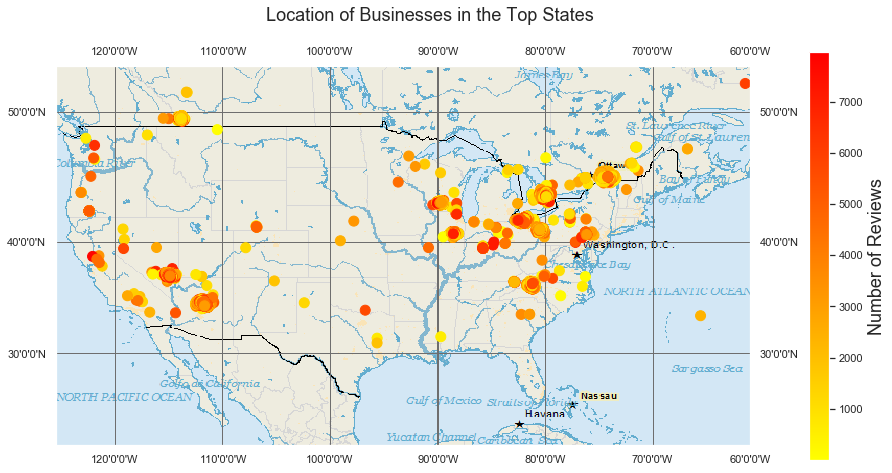

In [249]:
'''account for inconsistencies in reporting of coordinate values
    - latitude should be positive for top states, which are located North
    - longitude should be negative for top states, which are located West
    - remove outliers, which would not feasibly correspond to a state
    - drop entries with undefined values
'''
def clean_coordinates(df):
    state_latitude = []
    state_longitude = []
    for s in df.state.unique():
        for c in ['latitude', 'longitude']:
            if s in top_states.state_name.unique():
                s_c = df.loc[df['state'] == s, c]\
                        .apply(lambda x: np.sqrt(x ** 2))
                s_c = s_c[np.abs(s_c - s_c.mean()) <= (3 * s_c.std())]
                if c == 'longitude':
                    state_longitude.append(s_c.apply(lambda x: x * -1))
                else: 
                    state_latitude.append(s_c)
            elif c == 'longitude':
                state_longitude.append(df.loc[df['state'] == s, c])
            else:
                state_latitude.append(df.loc[df['state'] == s, c])
    return df.drop(['latitude', 'longitude'], axis=1)\
             .join(pd.DataFrame({'latitude': pd.concat(state_latitude),
                                 'longitude': pd.concat(state_longitude)}),
                   how='inner')

#clean coordinates in businesses dataframe
businesses = clean_coordinates(businesses)

#create color map using review count per business to determine hue
color_by_review_count = {id: color for id, color
                         in zip(businesses.sort_values('review_count')
                                          .business_id,
                                sns.color_palette('autumn_r',
                                                  len(businesses)))}

#create color column by mapping color_by_review_count dict to business_id
businesses.loc[:, 'color'] = businesses.business_id.map(color_by_review_count)

'''plot coordinates on map of north america
    - with color as the number of reviews in each business
'''
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(businesses.longitude, businesses.latitude,
           c=businesses.color, s=100)
ax.imshow(plt.imread("Mercator-North-America.png"),
          extent=[-126, -60, 20, 56])
ax.set(xticks=[-120.4, -110.1, -100, -89.7, -79.5, -69.3, -60],
       xticklabels=[str(i)[1:]+"'0'0'W" for i in np.arange(-120, -50, 10)],
       yticks=[20, 28.7, 39.3, 51.7],
       yticklabels=['', "30'0'0'N", "40'0'0'N", "50'0'0'N"])
ax.tick_params('x', labelbottom=True, labeltop=True)
ax.tick_params('y', labelleft=True, labelright=True)
cax, _ = colorbar.make_axes(ax, location='right', fraction=0.1,
                            pad=0.07, shrink=0.5)
cbar = colorbar.ColorbarBase(cax, cmap=plt.cm.autumn_r,
                             norm=colors.Normalize(vmin=businesses.review_count\
                                                                  .min(),
                                                   vmax=businesses.review_count\
                                                                  .max()))
cbar.set_label('Number of Reviews', fontsize=18)
fig.text(0.32, 0.72, 'Location of Businesses in the Top States', fontsize=18);

#### Business Count and Average Star Rating
***
[Top](#Table-of-Contents)

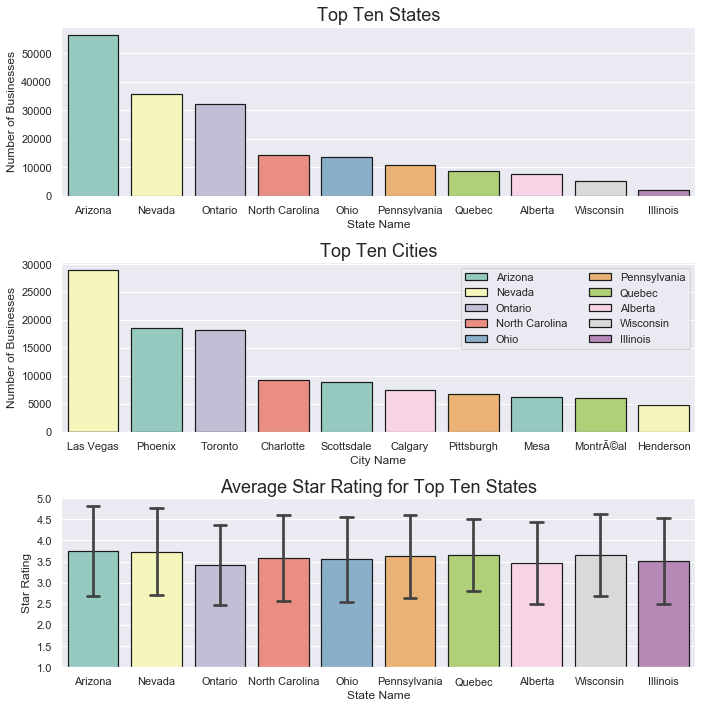

In [242]:
'''- plot number of businesses in each of the top 10 states
   - plot number of businesses in each of the top 10 cities, colored by state
   - plot average star rating for each of the top 10 states, capped with standard deviation
'''
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
sns.countplot(x='state_name', data=top_states,
              order=top_states.state_name.value_counts().index.tolist(),
              linewidth=1.2, edgecolor='k', palette='Set3', ax=axes[0])
sns.countplot(x='city', hue='state_name', dodge=False,
              data=top_states[top_states.city.isin(top_states.city\
                                                             .value_counts()[:10]\
                                                             .index.tolist())],
              hue_order=top_states.state_name.value_counts().index.tolist(),
              order=top_states.city.value_counts()[:10].index.tolist(),
              linewidth=1.2, edgecolor='k', palette='Set3', ax=axes[1])
sns.barplot(x='state_name', y='stars', data=top_states,
            order=top_states.state_name.value_counts().index.tolist(),
            ci='sd', capsize=0.2, palette='Set3',
            linewidth=1.2, edgecolor='k', ax=axes[2])
axes[0].set_title('Top Ten States', fontsize=18)
axes[0].set(xlabel='State Name', ylabel='Number of Businesses')
axes[1].set_title('Top Ten Cities', fontsize=18)
axes[1].set(xlabel='City Name', ylabel='Number of Businesses')
axes[1].legend(loc='upper right', ncol=2)
axes[2].set_title('Average Star Rating for Top Ten States', fontsize=18)
axes[2].set(xlabel='State Name', ylabel='Star Rating', 
            ylim=(1,5), yticks=np.arange(1, 5.5, 0.5))
plt.tight_layout();

#### Average Number of Reviews Per Star Rating
***
[Top](#Table-of-Contents)

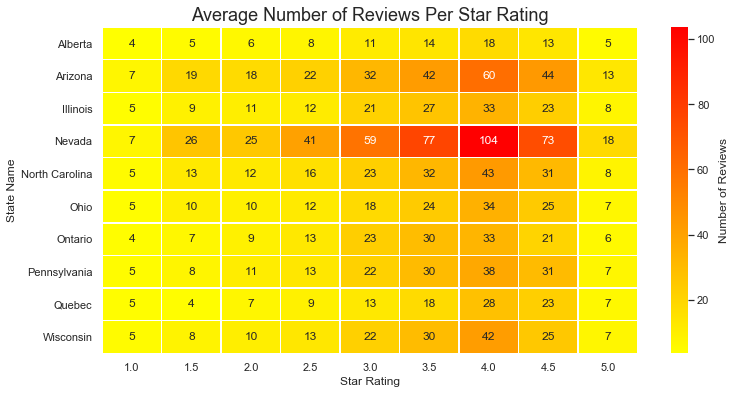

In [243]:
#plot the average number of reviews per star rating for the top states
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pd.pivot_table(top_states, aggfunc=np.mean,
                           values='review_count', index='state_name', columns='stars'),
            cmap=plt.cm.autumn_r, cbar_kws={'label': 'Number of Reviews'},
            annot=True, fmt='.0f', linewidths=0.5, ax=ax)
ax.set_title('Average Number of Reviews Per Star Rating', fontsize=18)
ax.set(xlabel='Star Rating', ylabel='State Name');

#### Distribution of Star Ratings for Top States
***
[Top](#Table-of-Contents)

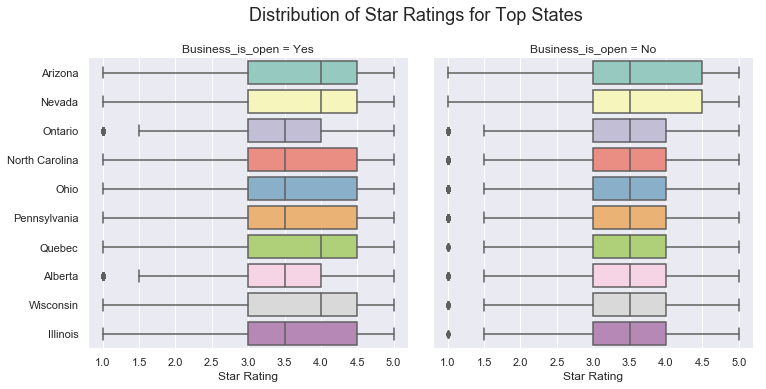

In [244]:
#create 'Business_is_open' column by mapping strings to values from 'is_open' column 
top_states = top_states.assign(Business_is_open=top_states.is_open\
                                                          .map({0: 'No', 1: 'Yes'}))

#plot distribution of star ratings for businesses in the top states
sns.set_style('darkgrid')
ax = sns.catplot(x='stars', y='state_name', col='Business_is_open',
                 order=top_states.state_name.value_counts().index.tolist(),
                 data=top_states, kind='box', palette='Set3', height=5.5)
ax.set(xlabel='Star Rating', ylabel='', xticks=np.arange(1, 5.5, 0.5))
plt.subplots_adjust(top=0.85)
ax.fig.suptitle('Distribution of Star Ratings for Top States',
                x=0.55, fontsize=18);

## Categories
***
[Top](#Table-of-Contents)

In [245]:
#view categories dataframe index/column summary and memory usage
print('CATEGORIES OVERVIEW\n')
print(categories.info())
print(categories.head())

#view number of unique parent categories
parents = sorted([c for c in set([c[0] for c in categories.parents if c])])
print('\nNumber of Unique Parent Tags: {}'.format(len(parents)))

#view parent categories
print('\nParent Tags for Yelp Categories:\n')
for q1, q2, q3, q4 in zip_longest(parents[:30], parents[30:60],
                                  parents[60:90], parents[90:], fillvalue=''):
    print('{:<25}{:<25}{:<25}{}'.format(q1, q2, q3, q4))

CATEGORIES OVERVIEW

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 5 columns):
alias                1539 non-null object
country_blacklist    349 non-null object
country_whitelist    518 non-null object
parents              1539 non-null object
title                1539 non-null object
dtypes: object(5)
memory usage: 60.2+ KB
None
          alias         country_blacklist country_whitelist          parents  \
0    3dprinting                       NaN               NaN  [localservices]   
1     abruzzese                       NaN              [IT]        [italian]   
2  absinthebars                       NaN              [CZ]           [bars]   
3     acaibowls  [MX, PL, TR, AR, CL, IT]               NaN           [food]   
4   accessories                       NaN               NaN        [fashion]   

           title  
0    3D Printing  
1      Abruzzese  
2  Absinthe Bars  
3     Acai Bowls  
4    Accessories  

Number of Unique Parent

## Food Industry
- [Business Profiles](#Food-Industry-Business-Profiles)
- [Reviews](#Food-Industry-Reviews)
***
[Top](#Table-of-Contents)

### Food Industry Business Profiles
***
[Top](#Table-of-Contents)

In [248]:
#create list of parent tags pertaining to food-related businesses
food_categories = ['bars','breweries','cafes','donburi','food',
                   'gourmet','localflavor','restaurants','wineries']

#create list of all tags that have food categories as their parent tag
food_tags = categories.iloc[[index for index, parent in categories.parents.items()
                             if any(tag in food_categories for tag in parent)]]\
                      .title.str.lower().tolist()

#create mask for businesses with food-related category tags
food_mask = [any(category in tags for category in food_tags)
             if tags else False
             for (index, tags) in businesses.categories\
                                            .str.lower().str.split(', ')\
                                            .items()]

#create dataframe of businesses pertaining to the food industry
food_industry = businesses[food_mask]

#view food_industry dataframe index/column summary and memory usage
print('FOOD INDUSTRY OVERVIEW\n')
print(food_industry.info())

#view top ten food tags
print('\nTop 10 Food Tags: ')
for i, tag in enumerate(pd.Series([tag for tag_list in
                                   food_industry.categories.str.split(', ').tolist()
                                   for tag in tag_list]).value_counts()[:10]\
                                                        .index.tolist()):
    print('{}. {}'.format(i+1, tag))

#view summary of central tendency, dispersion, and shape for the food_industry
print('\nDescriptive Statistics:')
print(food_industry.describe())

FOOD INDUSTRY OVERVIEW

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73536 entries, 0 to 188590
Data columns (total 17 columns):
address         73536 non-null object
attributes      71567 non-null object
business_id     73536 non-null object
categories      73536 non-null object
city            73536 non-null object
hours           55299 non-null object
is_open         73536 non-null int64
name            73536 non-null object
neighborhood    73536 non-null object
postal_code     73536 non-null object
review_count    73536 non-null int64
stars           73536 non-null float64
state           73536 non-null object
state_name      73144 non-null object
latitude        73535 non-null float64
longitude       73536 non-null float64
color           73536 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 10.1+ MB
None

Top 10 Food Tags: 
1. Restaurants
2. Food
3. Nightlife
4. Bars
5. Coffee & Tea
6. Sandwiches
7. Fast Food
8. American (Traditional)
9. Pizza
10. Burg

### Food Industry Reviews
***
[Top](#Table-of-Contents)

In [225]:
#create DataFrame of reviews from the food industry with at least 200 reviews
top_reviews = pd.concat([c.loc[c.business_id\
                                .isin(food_industry[food_industry.review_count >= 200
                                                    ].business_id.tolist())] 
                         for c in review_chunks])

In [271]:
'''split top reviews by sentiment inferred from rating
    - 'negative' if rated 1, 2 stars
    - 'positive' if rated 4, 5 stars
'''
negative_reviews = top_reviews[top_reviews.stars < 3]
positive_reviews = top_reviews[top_reviews.stars > 3]

#view dataframes of top reviews by sentiment
print('Negative Food Industry Reviews\n')
print(negative_reviews.info())
print(negative_reviews.head())
print('\nPositive Food Industry Reviews\n')
print(positive_reviews.info())
print(positive_reviews.head())

Negative Food Industry Reviews

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319968 entries, 0 to 5996994
Data columns (total 9 columns):
business_id    319968 non-null object
cool           319968 non-null int64
date           319968 non-null datetime64[ns]
funny          319968 non-null int64
review_id      319968 non-null object
stars          319968 non-null int64
text           319968 non-null object
useful         319968 non-null int64
user_id        319968 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 24.4+ MB
None
               business_id  cool       date  funny               review_id  \
0   iCQpiavjjPzJ5_3gPD5Ebg     0 2011-02-25      0  x7mDIiDB3jEiPGPHOmDzyw   
3   elqbBhBfElMNSrjFqW3now     0 2011-02-25      0  Er4NBWCmCD4nM8_p1GRdow   
9   atVh8viqTj-sqDJ35tAYVg     1 2012-11-09      2  LWUtqzNthMM3vpWZIFBlPw   
21  u73j2VQ3TGWdMO-AG7MABw     0 2017-07-06      0  7EgEjUpcb8q-B5dPCMvkaQ   
25  f-v1fvtnbdw_QQRsCnwH-g     0 2017-11-18   

# Data Wrangling
- [Text Pre-processing](#Text-Pre-processing)
- [Feature Extraction](#Feature-Extraction)
    - [Dictionary](#Dictionaries)
    - [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
***
[Top](#Table-of-Contents)

## Text Pre-processing
- Tokenization: 
<br>Remove punctuation/special characters and transform passages from one long string into lists of word strings
- Normalization: 
<br>Convert all text to lower case, expand contractions, remove numerals and accent marks
- Stopwords Removal: 
<br>Remove words below three characters, and those which contribute little to overall meaning
- Lemmatization: 
<br>Eliminate affixes from a word by capturing the canonical forms based on a word's lemma, or chosen representative,
<br>in this case assigning a Verb category tag to the tokenized parts of a sentence
***
[Top](#Table-of-Contents)

In [259]:
#define function to preprocess comments
def preprocess(text):
    tokens = []
    for token in simple_preprocess(text, deacc=True):
        if token not in STOPWORDS and len(token) > 3:
            tokens.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return tokens

In [260]:
#show more characters per column
pd.options.display.max_colwidth = 100

#preprocess negative reviews
negative_tokens = negative_reviews.text.apply(preprocess)
print(negative_reviews.text.head())
negative_tokens.head()

0     The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo / Fort Apache. The che...
3     Back in 2005-2007 this place was my FAVORITE thai place EVER. I'd go here ALLLLL the time. I nev...
9     Food is pretty good, not gonna lie. BUT you have to make sacrifices if you choose to eat there. ...
21    Food was alright, the service was HORRIBLE! Both of our orders came out incorrect after waiting ...
25    I have to write a review on the Fractured Prune. First off I love doughnuts second I used to wor...
Name: text, dtype: object


0     [pizza, okay, best, prefer, biaggio, flamingo, fort, apache, chef, better, style, pizza, pizzeri...
3     [place, favorite, thai, place, alllll, time, complaints, start, know, busy, service, start, suck...
9     [food, pretty, good, gonna, sacrifice, choose, literally, take, hour, hour, half, deliver, food,...
21    [food, alright, service, horrible, order, come, incorrect, wait, extremely, long, write, order, ...
25    [write, review, fracture, prune, love, doughnuts, second, work, bakery, know, little, almighty, ...
Name: text, dtype: object

In [264]:
#preprocess positive reviews
positive_tokens = positive_reviews.text.apply(preprocess)
print(positive_reviews.text.head())
positive_tokens.head()

1     I love this place! My fiance And I go here atleast once a week. The portions are huge! Food is a...
4     Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above an...
7     AMAZING!!!\n\n I was referred here by a friend and at first thought "Korean and Mexican?? WEIRD....
8     Ribs = amazing\n2 hour wait time= not so amazing, but understandable. \n\nThis place would get 5...
14    Sansotei serves some top notch ramen. They take no reservations, so my company of five had to wa...
Name: text, dtype: object


1     [love, place, fiance, atleast, week, portion, huge, food, amaze, love, carne, asada, great, lunc...
4      [delicious, healthy, food, steak, amaze, fish, pork, awesome, service, thing, place, worth, penny]
7     [amaze, refer, friend, think, korean, mexican, weird, dont, know, husband, area, think, let, fri...
8     [rib, amaze, hour, wait, time, amaze, understandable, place, star, expand, restaurant, rib, amaz...
14    [sansotei, serve, notch, ramen, reservations, company, wait, outside, half, hour, guess, normal,...
Name: text, dtype: object

In [268]:
#revert display settings
pd.reset_option('display.max_colwidth')

## Feature Extraction
- [Dictionary](#Dictionaries)
<Br>A mapping between words and their integer ids, created from the normalized tokens in each corpus (negative and positive reviews)
<Br>by sweeping across them, assigning a unique integer id to each word, then collecting word counts and relevant statistics
- [Bag-of-Words Corpus](#Bag-of-Words-Corpora)
<Br>Tokenized documents converted into vectors, by counting the number of occurrences of each distinct word, converting the word to
<Br>its integer word id, and returning the result as a sparse vector, disregarding grammar and even word order but keeping multiplicity
***
[Top](#Table-of-Contents)

### Dictionaries
- from each set of tokens

In [4]:
#create dictionaries
negative_dict = Dictionary(negative_tokens)
positive_dict = Dictionary(positive_tokens)

### Bag of Words Corpora 
- format which can be plugged into the model

In [6]:
#create bag of words corpora
negative_corpus = [negative_dict.doc2bow(text) for text in negative_tokens]
positive_corpus = [positive_dict.doc2bow(text) for text in positive_tokens]

# Baseline Model
- [Training](#Baseline---Latent-Dirichlet-Allocation-Model)
- [Results](#Baseline-Results)
    - [Topics](#Baseline---Topics)
    - [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
    - [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
    - [Summary](#Baseline---Summary)
***
[Top](#Table-of-Contents)

## Baseline - Latent Dirichlet Allocation Model
- Using Gensim's LdaModel module, which is streamed and runs in constant memory with respect to the number of documents;
<br>meaning training documents may come in sequentially, requiring no random access, and the size of the training corpus does not affect memory footprint
- In this case it is a unigram model as each word has been vectorized individually, ignoring context and phrasing

#train baseline lda models
negative_unigrams_lda = LdaModel(negative_corpus,
                                 num_topics=10,
                                 id2word=negative_dict)
positive_unigrams_lda = LdaModel(positive_corpus,
                                 num_topics=10,
                                 id2word=positive_dict)

## Baseline Results
- [Topics](#Baseline---Topics)
- [Negative Model Visualization](#Baseline---Negative-Unigrams-pyLDAvis)
- [Positive Model Visualization](#Baseline---Positive-Unigrams-pyLDAvis)
- [Summary](#Baseline---Summary)
***
[Top](#Table-of-Contents)

### Baseline - Topics

In [269]:
#define function to view top N topics in Gensim LDA model
def top_n_topics(lda_model, num_words):
    for topic, words in lda_model.print_topics(num_words=num_words):
        print('Topic: {} \nWords: {}'.format(topic, words))

In [11]:
#view topics
print('NEGATIVE LDA TOPICS')
top_n_topics(negative_unigrams_lda, 5)
print('\nPOSITIVE LDA TOPICS')
top_n_topics(positive_unigrams_lda, 5)

NEGATIVE LDA TOPICS
Topic: 0 
Words: 0.035*"breakfast" + 0.030*"coffee" + 0.024*"egg" + 0.014*"brunch" + 0.014*"toast"
Topic: 1 
Words: 0.027*"place" + 0.025*"like" + 0.015*"look" + 0.012*"drink" + 0.009*"people"
Topic: 2 
Words: 0.076*"beer" + 0.049*"wine" + 0.037*"glass" + 0.025*"bottle" + 0.021*"beers"
Topic: 3 
Words: 0.019*"order" + 0.016*"fry" + 0.016*"good" + 0.014*"like" + 0.013*"taste"
Topic: 4 
Words: 0.019*"room" + 0.012*"tell" + 0.011*"stay" + 0.011*"say" + 0.011*"go"
Topic: 5 
Words: 0.030*"order" + 0.026*"pizza" + 0.019*"like" + 0.018*"rice" + 0.018*"chicken"
Topic: 6 
Words: 0.039*"food" + 0.025*"place" + 0.024*"price" + 0.019*"restaurant" + 0.014*"good"
Topic: 7 
Words: 0.062*"food" + 0.048*"service" + 0.035*"place" + 0.029*"time" + 0.027*"good"
Topic: 8 
Words: 0.037*"buffet" + 0.020*"line" + 0.017*"crab" + 0.014*"cake" + 0.013*"vegas"
Topic: 9 
Words: 0.030*"order" + 0.025*"come" + 0.024*"wait" + 0.022*"table" + 0.019*"food"

POSITIVE LDA TOPICS
Topic: 0 
Words: 0.025

### Baseline - Negative Unigrams pyLDAvis
***
[Top](#Table-of-Contents)

In [15]:
#create pyLDAvis visualizations for unigram lda models
negative_unigrams_vis = pyLDAvis.gensim.prepare(negative_unigrams_lda,
                                                negative_corpus,
                                                negative_dict)

#view negative unigrams lda topics
print('Negative LDA Model - Unigrams')
negative_unigrams_vis

Negative LDA Model - Unigrams


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      27.453705        1       1  0.072737  0.128943
3      17.125057        1       2  0.072444 -0.167314
6      10.983758        1       3  0.056277 -0.053982
7      10.555140        1       4  0.093212  0.002253
1       8.104419        1       5  0.010153  0.112704
5       8.090684        1       6  0.090567 -0.164364
4       7.880209        1       7  0.033285  0.248201
8       4.638722        1       8  0.046043 -0.018239
0       3.294265        1       9  0.011067 -0.062307
2       1.874045        1      10 -0.485787 -0.025895, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
12     Default  320095.000000        food  320095.000000  30.0000  30.0000
66     Default  174887.000000     service  174887.000000  29.0000  29.0000
101    Default  254850.000000       order  254850.000000  28.0000  28.0000
466    Default   86643.000000     minutes   86643.000000  27.0000  27.0000
143    Default  123962.000000        wait  123962.000000  26.0000  26.0000
59     Default  222216.000000       place  222216.000000  25.0000  25.0000
1031   Default   24438.000000        beer   24438.000000  24.0000  24.0000
348    Default   61357.000000     chicken   61357.000000  23.0000  23.0000
24     Default   35708.000000       pizza   35708.000000  22.0000  22.0000
343    Default   28931.000000      buffet   28931.000000  21.0000  21.0000
221    Default  117986.000000       table  117986.000000  20.0000  20.0000
365    Default   98687.000000       drink   98687.000000  19.0000  19.0000
27     Default   64347.000000       price   64347.000000  18.0000  18.0000
73     Default  173955.000000        time  173955.000000  17.0000  17.0000
246    Default   52905.000000         fry   52905.000000  16.0000  16.0000
171    Default   85758.000000        tell   85758.000000  15.0000  15.0000
18     Default  180417.000000        like  180417.000000  14.0000  14.0000
44     Default  174458.000000        good  174458.000000  13.0000  13.0000
78     Default   19685.000000   breakfast   19685.000000  12.0000  12.0000
321    Default   29892.000000       sushi   29892.000000  11.0000  11.0000
71     Default   85210.000000       taste   85210.000000  10.0000  10.0000
217    Default   31264.000000        room   31264.000000   9.0000   9.0000
537    Default   17202.000000       glass   17202.000000   8.0000   8.0000
957    Default   15769.000000        wine   15769.000000   7.0000   7.0000
419    Default   42396.000000       sauce   42396.000000   6.0000   6.0000
141    Default  100966.000000         say  100966.000000   5.0000   5.0000
577    Default   34719.000000      burger   34719.000000   4.0000   4.0000
267    Default   25539.000000        rice   25539.000000   3.0000   3.0000
728    Default   28037.000000        line   28037.000000   2.0000   2.0000
1076   Default   16708.000000      coffee   16708.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
6859   Topic10     493.264740     slowest     494.137512   3.9753  -6.4734
1970   Topic10     486.248688       amuse     487.121490   3.9753  -6.4878
9831   Topic10     460.191071        chai     461.063782   3.9752  -6.5428
40232  Topic10     459.146301  biz_photos     460.019135   3.9752  -6.5451
8380   Topic10     457.785797        jazz     458.658569   3.9752  -6.5481
10057  Topic10     443.752197    validate     444.625092   3.9751  -6.5792
1880   Topic10    1541.333008         win    1546.234375   3.9739  -5.3341
4240   Topic10     562.273071     nutella     563.582092   3.9747  -6.3425
7011   Topic10     553.272766       shelf     555.260803   3.9735  -6.3586
4309   Topic10    1415.932129       shots    1484.434082   3.9298  -5.4189
4446   Topic10    1170.107178     tequila    1236.340210   3.9220  -5.6096
1074   To

### Baseline - Positive Unigrams pyLDAvis
***
[Top](#Table-of-Contents)

In [14]:
#create pyLDAvis visualizations for unigram lda models
positive_unigrams_vis = pyLDAvis.gensim.prepare(positive_unigrams_lda,
                                                positive_corpus,
                                                positive_dict)

#view positive unigrams lda topics
print('Positive LDA Model - Unigrams')
positive_unigrams_vis

Positive LDA Model - Unigrams


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      15.430524        1       1 -0.156415 -0.030754
3      15.114373        1       2 -0.193227 -0.007477
6      14.023523        1       3 -0.184477 -0.017054
2      11.232782        1       4  0.077379  0.088904
9      10.553345        1       5  0.048805  0.094643
4      10.081965        1       6 -0.185095 -0.064558
8       9.077689        1       7  0.054776  0.024289
0       8.303888        1       8 -0.003748  0.043048
5       3.105014        1       9  0.268194 -0.331667
7       3.076894        1      10  0.273807  0.200627, topic_info=     Category           Freq        Term          Total  loglift  logprob
term                                                                     
10    Default  765535.000000       great  765535.000000  30.0000  30.0000
9     Default  862113.000000        food  862113.000000  29.0000  29.0000
561   Default  155407.000000       pizza  155407.000000  28.0000  28.0000
16    Default  857954.000000       place  857954.000000  27.0000  27.0000
30    Default  491083.000000     service  491083.000000  26.0000  26.0000
233   Default  228140.000000         fry  228140.000000  25.0000  25.0000
48    Default  234516.000000     chicken  234516.000000  24.0000  24.0000
5     Default  176419.000000      cheese  176419.000000  23.0000  23.0000
337   Default  135106.000000      burger  135106.000000  22.0000  22.0000
69    Default  515604.000000       order  515604.000000  21.0000  21.0000
168   Default  112463.000000   breakfast  112463.000000  20.0000  20.0000
245   Default   78046.000000       tacos   78046.000000  19.0000  19.0000
19    Default  188308.000000       sauce  188308.000000  18.0000  18.0000
13    Default  414319.000000        love  414319.000000  17.0000  17.0000
58    Default  822021.000000        good  822021.000000  16.0000  16.0000
131   Default   87015.000000      coffee   87015.000000  15.0000  15.0000
358   Default  182535.000000        dish  182535.000000  14.0000  14.0000
167   Default  316603.000000        best  316603.000000  13.0000  13.0000
260   Default  105981.000000        roll  105981.000000  12.0000  12.0000
145   Default  144065.000000       salad  144065.000000  11.0000  11.0000
137   Default  210603.000000    friendly  210603.000000  10.0000  10.0000
1055  Default  115267.000000    sandwich  115267.000000   9.0000   9.0000
268   Default   88600.000000        rice   88600.000000   8.0000   8.0000
72    Default  210144.000000       price  210144.000000   7.0000   7.0000
148   Default  180148.000000       staff  180148.000000   6.0000   6.0000
50    Default   59629.000000        chip   59629.000000   5.0000   5.0000
0     Default  277385.000000       amaze  277385.000000   4.0000   4.0000
95    Default  503329.000000        time  503329.000000   3.0000   3.0000
269   Default  115426.000000       sushi  115426.000000   2.0000   2.0000
1362  Default   70241.000000      buffet   70241.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
6353  Topic10    2177.199951     thicker    2178.048584   3.4809  -6.6513
2427  Topic10    9583.985352       pesto    9587.842773   3.4808  -5.1693
731   Topic10   35220.203125       pasta   39295.847656   3.3718  -3.8678
1840  Topic10    5801.577148     ricotta    6332.351562   3.3937  -5.6712
147   Topic10   24916.496094       slice   43916.492188   2.9145  -4.2138
3735  Topic10    5168.817383  prosciutto    6312.951172   3.2813  -5.7867
1386  Topic10    8991.244141        york   13280.002930   3.0912  -5.2331
1522  Topic10    6771.803711       olive    9815.660156   3.1100  -5.5166
4833  Topic10    5787.894043       dough    7998.036133   3.1578  -5.6736
1653  Topic10   13635.521484     sausage   30328.175781   2.6819  -4.8167
1607  Topic10   16388.148438      garlic   47108.757812   2.4253  -4.6328
604   Topic10    9963.833984    toppings   21912.6250

### Baseline - Summary 
LDA Models for positive and negative reviews, in this case trained on a corpus consisting only
of unigrams, both showed promising initial results. With the ten topics derived from each seeming to
harbor associations feasibly inline with human logic, i.e. ‘breakfast’, ‘coffee’, ‘brunch’ all appear
together, and ‘service’, ‘wait’, ‘rude’ also appearing together. An apparent downside to selecting such a
broad range of reviews was the lack of specificity when it came to the topics themselves, as many were
simply food categories, breakfast/pizzeria/burger items were all grouped together for both the negative
and positive topic models, instead of drawing different sentiment specific topics.
***
[Top](#Table-of-Contents)

# LDA Pipeline
- [Construction](#Custom-Transformers-and-Estimators)
    - [Yelp Review Selector](#Yelp-Review-Selector)
    - [Preprocess](#Preprocess)
    - [Vectorize](#Vectorize)
    - [LDA Estimator](#LDA-Estimator)
- [Food Industry Example](#LDA-Pipeline---Food-Industry)
    - [Negative Review Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
    - [Positive Review Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)
- [Individual Business Example](#LDA-Pipeline---Random-Individual-Business)
    - [Negative Review Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
    - [Positive Review Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)
***
[Top](#Table-of-Contents)

## Custom Transformers and Estimators
Wrapping previously loaded Gensim modules and Pandas, inheriting Scikit-Learn base classes
>Transformers:
- [Yelp Review Selector](#Yelp-Review-Selector)
- [Preprocess](#Preprocess)
- [Vectorize](#Vectorize)

> Estimator:
- [LDA Estimator](#LDA-Estimator)

### Yelp Review Selector
Selects Yelp reviews based on specified criteria
- Default parameters: (sentiment=None, star_threshold=0, atleast_nreviews=0, given_id=False, given_name=False, given_tags=False)
- Input Options (not case-sensitive, in order of superseding importance):
    - name of a business 
    - unique business_id 
    - list of categorical tags
    - all reviews by using 'select_all_reviews' as input str
- Parameters:
    - sentiment (str): 'positive', 'negative', or None (not case-sensitive)
    - star_threshold (int): rating used to infer sentiment, including number of stars specified
    - atleast_nreviews (int): only comments from businesses with at least the specified number of reviews will be included
    - given_id (bool): True if a specific business_id is given, False otherwise
    - given_name (bool): True if the name of a businenss is given, False otherwise
    - given_tags (bool): True if list of categorical tags is given, False otherwise
- Methods:
    - fit (X, y=None): returns self
    - select_reviews (X): returns pandas DataFrame of selected reviews
    - transform (X): calls select_reviews method, filters by sentiment, and returns only review text as a pandas Series
***
[Top](#Table-of-Contents)

In [272]:
class YelpReviewSelector(BaseEstimator, TransformerMixin):
    def __init__(self,
                 sentiment=None,
                 star_threshold=0,
                 atleast_nreviews=0,
                 given_id=False,
                 given_name=False,
                 given_tags=False):
        self.sentiment = sentiment
        self.star_threshold = star_threshold
        self.atleast_nreviews = atleast_nreviews
        self.given_id = given_id
        self.given_name = given_name
        self.given_tags = given_tags
    
    def fit(self, X, y=None):
        return self
    
    def select_reviews(self, X):
        if self.given_id:
            return pd.concat([c.loc[c.business_id == X]
                              for c in review_chunks],
                             sort=True)
        elif self.given_name:
            select_id = businesses[businesses.name.str.lower() == X.lower()
                                   ].business_id.iloc[0]
            return pd.concat([c.loc[c.business_id == select_id]
                              for c in review_chunks],
                             sort=True)
        elif self.given_tags:
            assert isinstance(X, list), "'X' must be a list of tags"
            X = [tag.lower() for tag in X]
            mask = [any(c in tags for c in X)
                    for tags in businesses.categories.str.lower().str.split(', ')]
            tagged_businesses = businesses[mask]
            atleast_nreviews = tagged_businesses[tagged_businesses.review_count
                                                 >= self.atleast_nreviews]
            return pd.concat([c.loc[c.business_id\
                                     .isin(atleast_nreviews.business_id.tolist())]
                                    for c in review_chunks],
                             sort=True)
        assert X == 'select_all_reviews',\
               "'X' not recognized,\
                specify 'given_name','given_tags', or 'select_all_reviews'"
        assert self.atleast_nreviews >= 200,\
               "Too many reviews have been selected;\
                without tags, 'atleast_nreviews' threshold >= 200 required" 
        atleast_nreviews = businesses[businesses.review_count
                                      >= self.atleast_nreviews]
        return pd.concat([c.loc[c.business_id\
                                 .isin(atleast_nreviews.business_id.tolist())]
                          for c in review_chunks],
                         sort=True)
        
    def transform(self, X):
        selected_reviews = self.select_reviews(X)
        if self.sentiment.lower() == 'positive':
            return selected_reviews[selected_reviews.stars
                                    >= self.star_threshold].text
        elif self.sentiment.lower() == 'negative':
            return selected_reviews[selected_reviews.stars
                                    <= self.star_threshold].text
        else:
            return selected_reviews.text

### Preprocess
Pre-process text data, in this case the Yelp reviews themselves, per specifications; with the option to expand potential vector space with n-grams
- Default parameters: (bigrams=False, trigrams=False, min_count=2, threshold=0.1)
- Input Options:
    - container of text documents, wherein each is assumed to be in the form of a single string
- Parameters:
    - bigrams (bool): True to create new bigram tokens from common multi-word expressions in corpus, False otherwise
    - trigrams (bool): True to create new trigram tokens from common multi-word expressions in corpus, False otherwise
    - min_count (int): Minimum number of occurrences for token to be considered in n-gram formation
    - threshold (int): score threshold phrase must meet for forming n-grams, higher meaning fewer n-grams are formed
- Methods:
    - fit (X, y=None): returns self
    - transform (X): returns list of lists, wherein each is a pre-processed document that has been tokenized, normalized, lemmatized, with stopwords removed
***
[Top](#Table-of-Contents)

In [273]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self,
                 bigrams=False,
                 trigrams=False,
                 min_count=2,
                 threshold=0.1):
        self.bigrams = bigrams
        self.trigrams = trigrams
        self.min_count = min_count
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tokens = [[WordNetLemmatizer().lemmatize(token, pos='n') 
                   for token in simple_preprocess(text, deacc=True)
                   if ((token not in STOPWORDS) & (len(token) > 3))]
                   for text in np.asarray(X)]
        
        if self.bigrams | self.trigrams:
            bigram_model = Phraser(Phrases(tokens,
                                           min_count=self.min_count,
                                           threshold=self.threshold))
            if self.trigrams:
                trigram_model = Phraser(Phrases(bigram_model[tokens],
                                                threshold=self.threshold))
                n_grams = [trigram_model[bigram_model[d]] for d in tokens]
            else:
                n_grams = [bigram_model[d] for d in tokens]
        else:
            n_grams = tokens
        return n_grams

### Vectorize
Create a vector space of features, where each feature is a sparse vector extracted from each document, in this case preprocessed Yelp reviews, consisting of terms and term weights
- Default parameters: (tfidf=False, filter_vocab=True, filter_no_below=2, filter_n_freq=1)
- Input Options:
    - container of tokenized text documents
- Parameters:
    - tfidf (bool): True to utilize Term Frequency-Inverse Document Frequency term weights, False to utilize term frequency for weighting
    - filter_vocab (bool): True to filter the vocabulary of the corpus, False to use all terms 
    - filter_no_below (int): If filter_vocab, keep tokens which are contained in at least this many documents
    - filter_n_freq (int): If filter_vocab, filter out this number of the most frequent tokens that appear in the documents
- Methods:
    - dictionary (X): returns an instance Gensim's Dictionary module called on X 
    - corpus (X): calls dictionary method, and returns a bag-of-words(or n-grams) vector representation of X, with the option to filter the vocabulary inferred from the corpus
    - fit (X, y=None): returns self
    - transform (X): calls dictionary and corpus methods, and returns a tuple containing the results of each, respectively; with the option to use TF-IDF term weighting 
***
[Top](#Table-of-Contents)

In [274]:
class Vectorize(BaseEstimator, TransformerMixin):
    def __init__(self,
                 tfidf=False,
                 filter_vocab=True,
                 filter_no_below=2,
                 filter_n_freq=1):
        self.tfidf = tfidf
        self.filter_vocab = filter_vocab
        self.filter_no_below = filter_no_below
        self.filter_n_freq = filter_n_freq
    
    def dictionary(self, X):
        return Dictionary(X)
    
    def corpus(self, X):
        id2words = self.dictionary(X)
        if self.filter_vocab:
            id2words.filter_extremes(no_below=self.filter_no_below)
            id2words.filter_n_most_frequent(self.filter_n_freq)
        return [np.asarray(id2words.doc2bow(text)) for text in X]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dictionary = self.dictionary(X)
        corpus = self.corpus(X)
        if self.tfidf:
            corpus = TfidfModel(corpus)[corpus]
        return (corpus, dictionary)

### LDA Estimator
Trains an instance of Gensim's Latent Dirichlet Allocation Model, with the option to create an pyLDAvis figure from the result
- Default parameters: n_topics=10, passes=1, alpha='auto', eta='auto', visualize=False)
- Input Options:
    - container with a corpus (in the form of a vector space), and a trained Gensim Dictionary instance
- Parameters:
    - n_topics (int): number of latent topics to be extracted from the training corpus
    - passes (int): number of passes through the corpus during training
    - alpha (np.ndarray, 'auto'): 'auto' learns an asymmetric prior from the corpus, or a 1D array of length 'n_topics' that expresses a-priori belief for each topics' probability
    - eta (float, np.ndarray, 'auto'): A-priori belief on word probability, 'auto' to learn the asymmetric prior from the corpus; float for a symmetric prior over topic/word probability; 1D array of length = number of words in the corpus, to denote an asymmetric probability for each word; matrix of shape 'n_topics' and number of words in corpus, to assign a probability for each word-topic distribution
    - visualize (bool): True to create a pyLDAvis figure from the trained LDA model, False otherwise
- Methods:
    - fit (X, y=None): returns self
    - transform (X): returns trained instance of Gensim's LDA Model; if visualize, then list with trained model and a pyLDAvis figure of it
***
[Top](#Table-of-Contents)

In [275]:
class LDA_Estimator(BaseEstimator, TransformerMixin):
    def __init__(self,
                 n_topics=10,
                 passes=1,
                 alpha='auto',
                 eta='auto',
                 visualize=False):
        self.n_topics = n_topics
        self.passes = passes
        self.alpha = alpha
        self.eta = eta
        self.visualize = visualize
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lda_model = LdaModel(X[0],
                             num_topics=self.n_topics,
                             id2word=X[1],
                             passes=self.passes,
                             alpha=self.alpha,
                             eta=self.eta)
        if self.visualize:
            lda_vis = pyLDAvis.gensim.prepare(lda_model, X[0], X[1])
            return [lda_model, lda_vis]
        else:
            return lda_model

In [280]:
#define function to view lda model metrics and top words per topic
def lda_metrics(pipeline, lda_model, review_text, test_size, n_words):
    tokens = pipeline.named_steps['preprocessor'].transform(review_text)
    corpus, dictionary = pipeline.named_steps['vectorizer'].transform(tokens)
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=tokens,
                                     dictionary=dictionary)
    print('TOPICS')
    for i, t in lda_model.print_topics(num_words=n_words):
        print('Topic: {} \nWords: {}'.format(i, t))
    print('\nLog Perplexity: ', lda_model.log_perplexity(corpus))
    print('Variational Bound: ', lda_model.bound(corpus,
                                                 subsample_ratio=test_size))
    print('Coherence Score: ', coherence_model.get_coherence())
    coherence_per_topic = sorted({i: v for i, v
                                  in enumerate(coherence_model.get_coherence_per_topic())
                                  }.items(),
                                 reverse=True, key=lambda x: x[1])
    print('Coherence Per Topic')
    for t, c in coherence_per_topic:
        print('Topic {}: {}'.format(t, c))
    print('\n')

## LDA Pipeline - Food Industry
- [Negative Review Results](#LDA-Pipeline---Food-Industry---Negative-Review-Results)
- [Positive Review Results](#LDA-Pipeline---Food-Industry---Positive-Review-Results)
***
[Top](#Table-of-Contents)

In [223]:
#build pipeline to create LDA topic model from text series
lda_pipeline = Pipeline([
                        #tokenize, normalize, remove stop words, and create lemmas from text in yelp reviews
                        # - create trigrams from phrases in at least 5 documents, and a score of 3
                        ('preprocessor', Preprocess(trigrams=True,
                                                    min_count=5,
                                                    threshold=3)),
                        #vectorize
                        # - remove the top 3 tokens
                        # - remove tokens with less than 3 occurrences
                        ('vectorizer', Vectorize(filter_no_below=3,
                                                 filter_n_freq=3)),
                        #train lda model on corpus
                        ('lda_model', LDA_Estimator(visualize=True))
                         ])

In [224]:
#split negative food industry reviews into training and test sets
nr_train, nr_test = train_test_split(negative_reviews.text, test_size=0.2)
pr_train, pr_test = train_test_split(positive_reviews.text, test_size=0.2)

In [225]:
#fit training reviews to pipeline
negative_trigrams_lda, negative_trigrams_vis = lda_pipeline.fit_transform(nr_train)
positive_trigrams_lda, positive_trigrams_vis = lda_pipeline.fit_transform(pr_train)

c:\programdata\anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
c:\programdata\anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


### LDA Pipeline - Food Industry - Negative Review Results
***
[Top](#Table-of-Contents)

In [246]:
#view topics and scores
print('NEGATIVE LDA MODEL - Trigrams')
lda_metrics(lda_pipeline, negative_trigrams_lda, negative_reviews_test, 0.2, 5)

#visualize negative trigrams lda topics
negative_trigrams_vis

NEGATIVE LDA MODEL - Trigrams


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      28.046667        1       1  0.201345  0.023233
5      16.937424        1       2  0.063949 -0.037394
0      15.798682        1       3  0.187970  0.060148
8      14.398193        1       4 -0.117815 -0.127607
6       5.167436        1       5  0.076296  0.005137
2       4.987728        1       6 -0.074191 -0.130458
3       4.326171        1       7 -0.182557 -0.156435
4       4.006487        1       8  0.150377  0.016989
1       3.782444        1       9 -0.107275 -0.013114
9       2.548771        1      10 -0.198100  0.359500, topic_info=      Category          Freq                                Term  \
term                                                               
353    Default  27198.000000                               tasty   
529    Default  22275.000000                                hand   
260    Default  69026.000000                               smile   
149    Default  15491.000000                               plate   
10     Default  49918.000000                               drink   
98     Default  68876.000000                          neon_light   
250    Default  50907.000000                              overly   
187    Default  74270.000000                              reason   
25     Default  71169.000000                               order   
219    Default  28267.000000                             complex   
55     Default  16470.000000                                area   
128    Default  15461.000000                                vega   
4      Default  42353.000000                               asked   
488    Default  42698.000000                               sweet   
901    Default  14540.000000                            neighbor   
369    Default  26344.000000                              cheese   
32     Default  52722.000000                                rude   
37     Default  38024.000000                        stood_waited   
378    Default  10877.000000                              dinner   
155    Default  63574.000000                              subpar   
80     Default  44573.000000                               genre   
246    Default  22984.000000                     mother_birthday   
1598   Default   9142.000000                               fresh   
434    Default  12132.000000                               water   
343    Default  10642.000000                              placed   
511    Default  18512.000000                         cheese_ball   
399    Default  18048.000000                         pretty_good   
236    Default  28316.000000                             justify   
484    Default  11810.000000                              sloppy   
127    Default   9581.000000                                unco   
...        ...           ...                                 ...   
33753  Topic10    413.020142                           yellowish   
14869  Topic10    479.208588                          saturating   
453    Topic10    450.021545                      mean_seriously   
2591   Topic10   1078.718140                              entail   
17266  Topic10    356.756165                            playlist   
28196  Topic10    459.857178                         bunch_stuff   
1598   Topic10   9132.322266                               fresh   
3285   Topic10    660.552246                        decided_join   
2456   Topic10    631.507324                             markham   
389    Topic10    547.578247                           inspiring   
26425  Topic10    531.513916                           technical   
10691  Topic10    510.507385                             tatjana   
9472   Topic10    501.364624                          draft_beer   
9923   Topic10   1185.041870                   real_mexican_food   
68904  Topic10    442.749786                         astigmatism   
8234   Topic10    522.429382                 

### LDA Pipeline - Food Industry - Positive Review Results
***
[Top](#Table-of-Contents)

In [247]:
#view topics and scores
print('POSITIVE LDA MODEL - Trigrams')
lda_metrics(lda_pipeline, positive_trigrams_lda, positive_reviews_test, 0.2, 5)

#visualize positive trigrams lda topics
positive_trigrams_vis

POSITIVE LDA MODEL - Trigrams


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      33.036766        1       1 -0.216058 -0.043337
8      14.483808        1       2 -0.152985 -0.045018
3      14.244969        1       3 -0.136254 -0.003838
1      10.430905        1       4 -0.163112  0.009213
6       8.313873        1       5 -0.126364  0.005440
4       5.613126        1       6 -0.064116  0.064616
9       3.773973        1       7  0.181872  0.093127
5       3.637613        1       8  0.171060  0.151019
7       3.468686        1       9  0.261973  0.178077
0       2.996285        1      10  0.243983 -0.409300, topic_info=      Category           Freq                     Term          Total  \
term                                                                    
18     Default  596816.000000                     good  596816.000000   
135    Default  345917.000000           grabbing_drink  345917.000000   
587    Default  102589.000000              noodle_dish  102589.000000   
218    Default  144291.000000                    truly  144291.000000   
34     Default  285581.000000                    raved  285581.000000   
112    Default  224587.000000             creamed_corn  224587.000000   
32     Default  214147.000000                    pried  214147.000000   
48     Default  217871.000000               withdrawal  217871.000000   
60     Default  215866.000000                    taste  215866.000000   
824    Default   64262.000000                chef_hiro   64262.000000   
245    Default   64915.000000                   bertha   64915.000000   
580    Default   92185.000000                    haven   92185.000000   
51     Default  166645.000000                     best  166645.000000   
804    Default   58035.000000                deserving   58035.000000   
269    Default  100666.000000                   course  100666.000000   
308    Default  115760.000000                    issue  115760.000000   
191    Default  122209.000000            picture_speak  122209.000000   
153    Default   74379.000000                     date   74379.000000   
159    Default   48745.000000                     nice   48745.000000   
173    Default   66983.000000               experience   66983.000000   
86     Default   88299.000000                     plus   88299.000000   
591    Default   46855.000000                     rice   46855.000000   
16     Default   90086.000000                   flavor   90086.000000   
344    Default   64060.000000                   proven   64060.000000   
712    Default  102674.000000                belonging  102674.000000   
687    Default   67643.000000                  crumbly   67643.000000   
1164   Default   47292.000000                   finger   47292.000000   
121    Default  120035.000000              spicy_sauce  120035.000000   
47     Default   55285.000000                     vega   55285.000000   
720    Default   68523.000000         drinking_alcohol   68523.000000   
...        ...            ...                      ...            ...   
2343   Topic10    7065.466797                fish_chip    7065.678223   
1365   Topic10    5312.838867     waited_approx_minute    5313.014648   
1523   Topic10    4995.448730                 familiar    4995.628418   
811    Topic10    4091.645264             peanut_sauce    4091.820801   
3665   Topic10    4230.641602       satay_peanut_sauce    4230.825195   
3188   Topic10    3550.598877             couldn_stand    3550.779297   
6024   Topic10    3353.162598           place_get_busy    3353.338867   
4213   Topic10    3200.942871          finish_leftover    3201.115723   
2707   Topic10    3201.413330                    onion    3201.590576   
5513   Topic10    3049.934326  green_chili_pulled_pork    3050.116455   
3819   Topic10    3420.354248                  whiting    3420.558838   
1685   Topic10    2960.954102               definately    2961.135010   
816    Topic10    2700.5

##  LDA Pipeline - Random Individual Business 
- [Negative Review Results](#LDA-Pipeline---Random-Individual-Business---Negative-Review-Results)
- [Positive Review Results](#LDA-Pipeline---Random-Individual-Business---Positive-Review-Results)
***
[Top](#Table-of-Contents)

In [276]:
#random businesses with at least 500 reviews
sample_business = businesses[businesses.review_count > 500].sample(1)

sample_business

,address,attributes,business_id,categories,city,hours,is_open,name,neighborhood,postal_code,review_count,stars,state,state_name,color,latitude,longitude
135875,4005 N Scottsdale Rd,"{'Alcohol': 'none', 'BikeParking': 'True', 'Bu...",8nP8ghEpT6WFcM6tfqAaGA,"Ice Cream & Frozen Yogurt, Food, American (Tra...",Scottsdale,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,Sugar Bowl,,85251,569,3.5,AZ,Arizona,"(1.0, 0.0039215686274509665, 0.0)",33.493773,-111.925924


In [281]:
#build pipeline to create LDA model for negative reviews from a sample business
negative_lda_pipeline = Pipeline([
                        #select reviews corresponding to given business_id
                        ('selector', YelpReviewSelector(sentiment='negative', 
                                                        star_threshold=3, 
                                                        given_id=True)),
    
                        #tokenize, lemmatize, and make n_grams
                        ('preprocessor', Preprocess(trigrams=True)),
    
                        #vectorize
                        # - remove the top 3 tokens
                        # - remove tokens with less than 3 occurrences
                        ('vectorizer', Vectorize(filter_no_below=2,
                                                 filter_n_freq=4)),
    
                        #train lda model on corpus
                        ('lda_model', LDA_Estimator(n_topics=7,
                                                    passes=10,
                                                    visualize=True))
                                  ])

In [282]:
#build pipeline to create LDA model for positive reviews from a sample business
positive_lda_pipeline = Pipeline([                       
                        #select reviews corresponding to given business_id
                        ('selector', YelpReviewSelector(sentiment='positive', 
                                                        star_threshold=4, 
                                                        given_id=True)),
    
                        #tokenize, lemmatize, and make n_grams
                        ('preprocessor', Preprocess(trigrams=True)),
    
                        #vectorize
                        ('vectorizer', Vectorize(filter_no_below=2,
                                                 filter_n_freq=2)),
    
                        #train lda model on corpus
                        ('lda_model', LDA_Estimator(n_topics=5,
                                                    passes=10,
                                                    visualize=True))
                                  ])

### LDA Pipeline - Random Individual Business - Negative Review Results
***
[Top](#Table-of-Contents)

In [283]:
#fit negative lda pipeline to sample business
sample_negative_lda, sample_negative_vis = negative_lda_pipeline.fit_transform(
                                                      sample_business.business_id\
                                                                     .iloc[0]
                                                                               )

#get reviews used in lda model
sample_negative_reviews = negative_lda_pipeline.named_steps['selector']\
                                               .transform(
                                                      sample_business.business_id\
                                                                     .iloc[0]
                                                          )

c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [284]:
#show topics and metrics
print('Individual Business - Negative Reviews - Trigrams')
lda_metrics(pipeline=negative_lda_pipeline,
            lda_model=sample_negative_lda,
            review_text=sample_negative_reviews,
            test_size=1,
            n_words=5)

#show pyLDAvis figure
sample_negative_vis

Individual Business - Negative Reviews - Trigrams
TOPICS
Topic: 0 
Words: 0.010*"time" + 0.008*"mind" + 0.008*"health" + 0.008*"smell" + 0.007*"serving"
Topic: 1 
Words: 0.008*"room" + 0.008*"health" + 0.007*"great" + 0.006*"thrilled" + 0.006*"previous"
Topic: 2 
Words: 0.010*"smell" + 0.009*"health" + 0.007*"deserve" + 0.006*"great" + 0.006*"stale"
Topic: 3 
Words: 0.008*"real" + 0.008*"great" + 0.008*"fame" + 0.007*"wall" + 0.007*"care"
Topic: 4 
Words: 0.010*"real" + 0.009*"great" + 0.007*"health" + 0.007*"smell" + 0.006*"thrilled"
Topic: 5 
Words: 0.009*"allow" + 0.007*"health" + 0.007*"smell" + 0.006*"food" + 0.006*"annoying"
Topic: 6 
Words: 0.007*"allow" + 0.007*"great" + 0.007*"remembered" + 0.006*"health" + 0.005*"mortified"

Log Perplexity:  -6.999040295817565
Variational Bound:  -56251.04550534487
Coherence Score:  0.5768158675964129
Coherence Per Topic
Topic 6: 0.6159952921349425
Topic 3: 0.6113549674735197
Topic 2: 0.5923617258015892
Topic 1: 0.5716800117461822
Topic 0: 0.

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.058582 -0.004541       1        1  22.319082
1      0.003697  0.051150       2        1  17.206564
2      0.018713 -0.016987       3        1  15.886833
0     -0.003759 -0.041224       4        1  15.103629
3     -0.000295  0.017071       5        1  12.390219
5      0.035467 -0.008502       6        1  11.027508
6      0.004759  0.003032       7        1   6.066168, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
210   Default  40.000000           allow  40.000000  30.0000  30.0000
186   Default  23.000000        previous  23.000000  29.0000  29.0000
6     Default  26.000000            lack  26.000000  28.0000  28.0000
296   Default   7.000000            hope   7.000000  27.0000  27.0000
204   Default  34.000000            time  34.000000  26.0000  26.0000
223   Default  22.000000          eating  22.000000  25.0000  25.0000
25    Default  21.000000         present  21.000000  24.0000  24.0000
650   Default  33.000000      remembered  33.000000  23.0000  23.0000
535   Default  15.000000            size  15.000000  22.0000  22.0000
867   Default  22.000000          thrown  22.000000  21.0000  21.0000
286   Default  30.000000         deserve  30.000000  20.0000  20.0000
379   Default  14.000000           token  14.000000  19.0000  19.0000
181   Default  27.000000       mortified  27.000000  18.0000  18.0000
244   Default  34.000000            mind  34.000000  17.0000  17.0000
94    Default  14.000000           plate  14.000000  16.0000  16.0000
564   Default   3.000000       downright   3.000000  15.0000  15.0000
497   Default   3.000000          volume   3.000000  14.0000  14.0000
619   Default  12.000000        touristy  12.000000  13.0000  13.0000
184   Default  14.000000         picture  14.000000  12.0000  12.0000
327   Default  13.000000           crazy  13.000000  11.0000  11.0000
222   Default  12.000000            deck  12.000000  10.0000  10.0000
877   Default  12.000000            hair  12.000000   9.0000   9.0000
370   Default  24.000000   vanilla_cream  24.000000   8.0000   8.0000
531   Default  17.000000          pardon  17.000000   7.0000   7.0000
112   Default  36.000000            fame  36.000000   6.0000   6.0000
319   Default  11.000000         yelling  11.000000   5.0000   5.0000
529   Default   9.000000          option   9.000000   4.0000   4.0000
8     Default  18.000000    poor_service  18.000000   3.0000   3.0000
19    Default  21.000000          flavor  21.000000   2.0000   2.0000
141   Default  14.000000          update  14.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
181    Topic7   2.667441       mortified  27.829903   0.4575  -5.2082
370    Topic7   2.277969   vanilla_cream  24.385448   0.4317  -5.3661
158    Topic7   2.324281             god  26.381971   0.3732  -5.3460
25     Topic7   2.087428         present  21.758043   0.4584  -5.4534
159    Topic7   3.402686           great  56.276470  -0.0033  -4.9648
286    Topic7   2.393597         deserve  30.176937   0.2682  -5.3166
162    Topic7   3.158508          health  58.335854  -0.1137  -5.0393
21     Topic7   2.587807        horrible  39.952641   0.0656  -5.2386
117    Topic7   1.509162           germy  12.790854   0.6653  -5.7778
877    Topic7   1.463277            hair  12.112811   0.6889  -5.8087
714    Topic7   1.509669         drizzle  13.295814   0.6269  -5.7775
16     Topic7   1.737690     cream_cream  18.602577   0.4317  -5.6368
89     Topic7   2.397863            food  41.935425  -0.0591  -5.3148
267    Topic7   2.188523         theater  33.812847   0.0648  -5.4061
255    Topic7   2.062993          placed  29.552116   0.1404  -5.4652
14     Topic7   1.913340           cooky  24.628685   0.2474  -5.5405
51     Topic7   2.482605            real 

### LDA Pipeline - Random Individual Business - Positive Review Results
***
[Top](#Table-of-Contents)

In [285]:
#fit positive lda pipeline to sample business
sample_positive_lda, sample_positive_vis = positive_lda_pipeline.fit_transform(
                                                      sample_business.business_id\
                                                                     .iloc[0]
                                                                               )

#get reviews used in lda model
sample_positive_reviews = positive_lda_pipeline.named_steps['selector']\
                                               .transform(
                                                      sample_business.business_id\
                                                                     .iloc[0]
                                                          )

c:\programdata\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [286]:
#show topics and metrics
print('Avergage Business - Positive Reviews LDA Model')
lda_metrics(pipeline=positive_lda_pipeline,
            lda_model=sample_positive_lda,
            review_text=sample_negative_reviews,
            test_size=1,
            n_words=5)

#show pyLDAvis figure
sample_positive_vis

Avergage Business - Positive Reviews LDA Model
TOPICS
Topic: 0 
Words: 0.013*"request" + 0.009*"memorable" + 0.009*"server" + 0.009*"wife" + 0.009*"cute"
Topic: 1 
Words: 0.015*"fresh" + 0.010*"server" + 0.009*"memorable" + 0.008*"asian" + 0.007*"request"
Topic: 2 
Words: 0.010*"fresh" + 0.010*"unimpressed" + 0.010*"memorable" + 0.009*"server" + 0.009*"remember"
Topic: 3 
Words: 0.010*"fresh" + 0.009*"server" + 0.009*"memorable" + 0.008*"request" + 0.008*"wife"
Topic: 4 
Words: 0.009*"request" + 0.008*"headed" + 0.008*"fresh" + 0.008*"memorable" + 0.007*"celebration"

Log Perplexity:  -8.022352533513757
Variational Bound:  -65943.88427188993
Coherence Score:  0.5679179300321362
Coherence Per Topic
Topic 2: 0.6166766702086733
Topic 0: 0.5979195821940027
Topic 3: 0.5552912848629241
Topic 4: 0.5360080815793172
Topic 1: 0.5336940313157638




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.037607  0.019378       1        1  25.816074
3      0.002390 -0.030467       2        1  21.001833
2     -0.007914  0.012236       3        1  18.592936
4     -0.030825  0.018958       4        1  18.497839
0     -0.001258 -0.020105       5        1  16.091320, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
201   Default  41.000000      unimpressed  41.000000  30.0000  30.0000
22    Default  69.000000          request  69.000000  29.0000  29.0000
506   Default   7.000000   brownie_sundae   7.000000  28.0000  28.0000
45    Default  22.000000       love_cream  22.000000  27.0000  27.0000
55    Default  45.000000         remember  45.000000  26.0000  26.0000
164   Default  37.000000          looking  37.000000  25.0000  25.0000
29    Default  25.000000      unsurpassed  25.000000  24.0000  24.0000
371   Default  18.000000            dated  18.000000  23.0000  23.0000
419   Default  23.000000           longer  23.000000  22.0000  22.0000
43    Default  21.000000       late_night  21.000000  21.0000  21.0000
209   Default  48.000000             cute  48.000000  20.0000  20.0000
50    Default  18.000000             open  18.000000  19.0000  19.0000
306   Default  26.000000            smell  26.000000  18.0000  18.0000
175   Default  22.000000         probably  22.000000  17.0000  17.0000
53    Default  29.000000            place  29.000000  16.0000  16.0000
326   Default   6.000000  fashioned_cream   6.000000  15.0000  15.0000
169   Default  26.000000            niice  26.000000  14.0000  14.0000
441   Default  25.000000         american  25.000000  13.0000  13.0000
124   Default  11.000000            table  11.000000  12.0000  12.0000
65    Default  21.000000        delicious  21.000000  11.0000  11.0000
308   Default  35.000000        sprinkled  35.000000  10.0000  10.0000
82    Default  21.000000     fudge_sundae  21.000000   9.0000   9.0000
275   Default   3.000000       serve_food   3.000000   8.0000   8.0000
265   Default  17.000000             lack  17.000000   7.0000   7.0000
418   Default  11.000000            later  11.000000   6.0000   6.0000
425   Default  13.000000  scottsdale_road  13.000000   5.0000   5.0000
165   Default  13.000000          lottery  13.000000   4.0000   4.0000
31    Default  28.000000             wasn  28.000000   3.0000   3.0000
410   Default  23.000000              cry  23.000000   2.0000   2.0000
921   Default   5.000000           beaver   5.000000   1.0000   1.0000
...       ...        ...              ...        ...      ...      ...
209    Topic5  11.168913             cute  48.600517   0.3564  -4.7597
365    Topic5   4.533198     sundae_cream  14.801102   0.6436  -5.6614
93     Topic5  11.311693             wife  55.791344   0.2311  -4.7470
371    Topic5   5.082850            dated  18.550648   0.5323  -5.5470
545    Topic5   3.145655             able   9.207945   0.7528  -6.0268
167    Topic5  12.294228        memorable  73.019386   0.0453  -4.6637
23     Topic5  11.841961           server  69.891037   0.0516  -4.7012
65     Topic5   5.347144        delicious  21.544132   0.4333  -5.4963
180    Topic5   6.933265  recommend_place  33.526722   0.2509  -5.2365
285    Topic5   4.989158           creamy  20.359207   0.4206  -5.5656
1033   Topic5   3.137622         adorable   9.642862   0.7041  -6.0294
563    Topic5   3.138322          quality   9.717888   0.6966  -6.0292
410    Topic5   5.142931              cry  23.169413   0.3217  -5.5352
106    Topic5  11.112186            fresh  87.709427  -0.2391  -4.7648
175    Topic5   5.056859         probably  22.663801   0.3269  -5.5521
306    Topic5   5.536299            smell  26.761574   0.2512  -5.4615
227    Topic5   7.080461      celebration  42.184334   0.0422  -5.2155
107    Topic5   5.875253     